In [141]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import torch.nn.functional as F
import argparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
cd /content/drive/MyDrive/ECE1786/A2/

/content/drive/MyDrive/ECE1786/A2


In [144]:
data = pd.read_csv("data.tsv", sep="\t")
data.head()

,text,label
0,"smart and alert , thirteen conversations about...",1
1,"color , musical bounce and warm seas lapping o...",1
2,it is not a mass-market entertainment but an u...,1
3,a light-hearted french film about the spiritua...,1
4,my wife is an actress has its moments in looki...,1


In [145]:
data.shape

(10000, 2)

In [151]:
# TextDataset is Described in Section 3.3 of Assignment 2
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        df = pd.read_csv(f"{split}.tsv", sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

def get_accuracy(model, dataloader, device):
  correct = 0
  total = 0
  for text, label in dataloader:
    text.to(device)
    label.to(device)
    out = model(text)
    pred = (out>=0.0).squeeze().long() == label
    correct += int(sum(pred))
    #correct += pred.eq(label.view_as(pred)).sum().item()
    total += label.shape[0]
  return correct/total


def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                   
    # 3.3.2
    if args.overfit:
      train_dataset = TextDataset(glove, "overfit")
    else:
      train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
        
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on 
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with
    model = CNN_Model(glove, args.k1, args.k2, args.n1, args.n2, args.freeze)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr= args.learning_rate)
    criterion = torch.nn.BCEWithLogitsLoss()

    epoches, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    for epoch in range(args.num_epoch):
      total_train_loss = 0
      for text, label in train_dataloader:
        text.to(device)
        label.to(device)
        out = model(text)
        loss = criterion(out, label.float())
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      epoches.append(epoch+1)
      train_loss.append(total_train_loss/len(train_dataloader))
      train_acc.append(get_accuracy(model, train_dataloader, device))

      ### Validation loss
      total_val_loss = 0
      for text2, label2 in validation_dataloader:
        text2.to(device)
        label2.to(device)
        out2 = model(text2)

        loss2 = criterion(out2, label2.float())
        total_val_loss += loss2.item()
      val_loss.append(float(total_val_loss)/len(validation_dataloader))
      val_acc.append(get_accuracy(model, validation_dataloader, device))

      print("This is epoch {} with training loss {} and validation loss {} and train accuracy {} and validation accuracy {}".format(epoch+1, train_loss[-1], 
                                                                                                                                    val_loss[-1], train_acc[-1], val_acc[-1]))
    
    if args.save:
      torch.save(model.state_dict(), "model_cnn.pt")

    plt.title("Training Curve - Loss")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve - Accuracy")
    plt.plot(epoches, train_acc, label="Train")
    plt.plot(epoches, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()    

    return model

In [147]:
class CNN_Model(torch.nn.Module):
  def __init__(self, vocab, kernel_1, kernel_2, out_channel_1, out_channel_2, freeze):
    super().__init__()
    self.kernel_1 = kernel_1
    self.kernel_2 = kernel_2
    self.out_channel_1 = out_channel_1
    self.out_channel_2 = out_channel_2
    self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors, freeze=freeze)

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=out_channel_1, kernel_size=(kernel_1, 100),bias=False)
    self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=out_channel_2, kernel_size=(kernel_2, 100),bias=False)
    #self.pool = torch.nn.MaxPool2d(2,2)
    self.fc = torch.nn.Linear(out_channel_1+out_channel_2,1)
    self.do = torch.nn.Dropout(0.4)
    self.bn1 = torch.nn.BatchNorm2d(out_channel_1)
    self.bn2 = torch.nn.BatchNorm2d(out_channel_2)

  def forward(self, x):
    e = self.embedding(x)
    pool1 = torch.nn.MaxPool1d(e.shape[0]-self.kernel_1+1)
    pool2 = torch.nn.MaxPool1d(e.shape[0]-self.kernel_2+1)
    e = torch.transpose(e,0,1).unsqueeze(1)
    out1 = pool1(F.relu(self.conv1(e)).squeeze())
    out2 = pool2(F.relu(self.conv2(e)).squeeze())
    out1 = self.do(out1)
    out2 = self.do(out2)
    out = torch.cat((out1, out2), 1).squeeze()
    out = out.view(-1, self.out_channel_1+self.out_channel_2)
    out = self.fc(out)
    
    return out.squeeze()

In [96]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

Using device: cuda
This is epoch 1 with training loss 0.6736008524894714 and validation loss 0.7015349101275206 and train accuracy 0.66 and validation accuracy 0.565
This is epoch 2 with training loss 0.5219655632972717 and validation loss 1.7313267476856709 and train accuracy 0.5 and validation accuracy 0.5
This is epoch 3 with training loss 1.5340296030044556 and validation loss 0.6004091296344995 and train accuracy 0.86 and validation accuracy 0.671875
This is epoch 4 with training loss 0.3386281430721283 and validation loss 1.2133593633770943 and train accuracy 0.54 and validation accuracy 0.51125
This is epoch 5 with training loss 0.7245331406593323 and validation loss 0.8697624411433935 and train accuracy 0.76 and validation accuracy 0.5575
This is epoch 6 with training loss 0.523759663105011 and validation loss 0.5159746035933495 and train accuracy 0.96 and validation accuracy 0.7525
This is epoch 7 with training loss 0.18817584216594696 and validation loss 0.6727330824360251 an

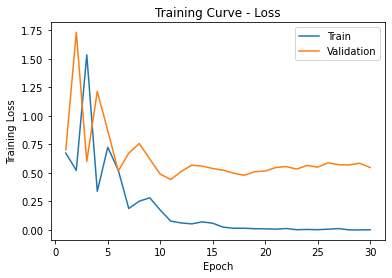

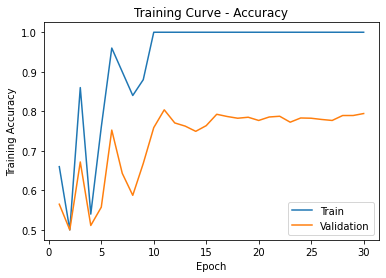

CNN_Model(
  (embedding): Embedding(400000, 100)
  (conv1): Conv2d(1, 50, kernel_size=(2, 100), stride=(1, 1), bias=False)
  (conv2): Conv2d(1, 50, kernel_size=(4, 100), stride=(1, 1), bias=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (do): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [97]:
### Overfit
args = AttrDict()
args_dict = {'emb_dim': 100,
             'batch_size':50, 
             'learning_rate':0.02,
             'num_epoch':30,
             'k1':2,
             'k2':4,
             'n1':50,
             'n2':50,
             'overfit':True,
             'freeze':True,
             'save':False}
args.update(args_dict)

main(args)

Using device: cuda
This is epoch 1 with training loss 0.4309116917429492 and validation loss 0.31411369843408465 and train accuracy 0.8778125 and validation accuracy 0.876875
This is epoch 2 with training loss 0.2824466979363933 and validation loss 0.2855194294825196 and train accuracy 0.89953125 and validation accuracy 0.890625
This is epoch 3 with training loss 0.24248731398256496 and validation loss 0.2737333192490041 and train accuracy 0.92015625 and validation accuracy 0.893125
This is epoch 4 with training loss 0.21915987570537254 and validation loss 0.2709670611657202 and train accuracy 0.93125 and validation accuracy 0.898125
This is epoch 5 with training loss 0.19681853178190067 and validation loss 0.271404302213341 and train accuracy 0.9353125 and validation accuracy 0.8925
This is epoch 6 with training loss 0.18061838927678764 and validation loss 0.24166623409837484 and train accuracy 0.94125 and validation accuracy 0.899375
This is epoch 7 with training loss 0.1597805041528

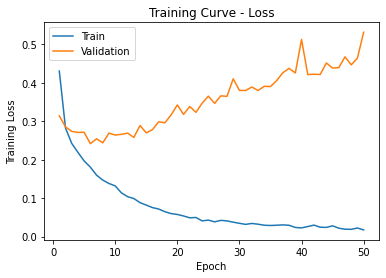

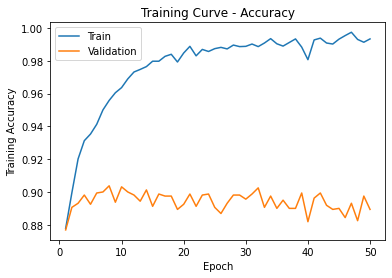

In [101]:
### 5.2.1
args = AttrDict()
args_dict = {'emb_dim': 100,
             'batch_size':50,
             'learning_rate':0.001,
             'num_epoch':50,
             'k1':2,
             'k2':4,
             'n1':50,
             'n2':50,
             'overfit':False,
             'freeze':True,
             'save':False}
args.update(args_dict)

model = main(args)

Using device: cuda
This is epoch 1 with training loss 0.4188053122488782 and validation loss 0.2927899267524481 and train accuracy 0.8978125 and validation accuracy 0.88625
This is epoch 2 with training loss 0.23241262463852763 and validation loss 0.25477665523067117 and train accuracy 0.93796875 and validation accuracy 0.900625
This is epoch 3 with training loss 0.15712169036851265 and validation loss 0.24371771328151226 and train accuracy 0.96421875 and validation accuracy 0.91
This is epoch 4 with training loss 0.10844122336129658 and validation loss 0.24672669917345047 and train accuracy 0.97921875 and validation accuracy 0.911875
This is epoch 5 with training loss 0.06884942910983227 and validation loss 0.2641496027354151 and train accuracy 0.9875 and validation accuracy 0.915625
This is epoch 6 with training loss 0.04445235195453279 and validation loss 0.2502935321535915 and train accuracy 0.99359375 and validation accuracy 0.9125
This is epoch 7 with training loss 0.026235524579

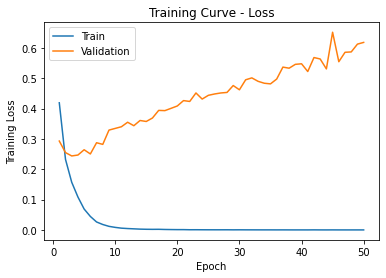

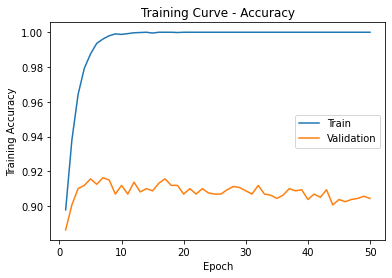

In [102]:
### 5.2.2
args = AttrDict()
args_dict = {'emb_dim': 100,
             'batch_size':50, 
             'learning_rate':0.001,
             'num_epoch':50,
             'k1':2,
             'k2':4,
             'n1':50,
             'n2':50,
             'overfit':False,
             'freeze':False,
             'save':True}
args.update(args_dict)

model = main(args)

In [152]:
torch.manual_seed(2)

device = torch.device('cpu')
print ("Using device:", device)

glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                   
test_dataset = TextDataset(glove, "test")
      
test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
model = CNN_Model(glove, args.k1, args.k2, args.n1, args.n2, args.freeze)
model.load_state_dict(torch.load('model_cnn.pt'))
model.eval()
model.to(device)
  
get_accuracy(model, test_dataloader, device)

Using device: cpu


0.925

In [105]:
param_list = []
for param in model.parameters():
  param_list.append(param)

In [131]:
def print_closest_cosine_words(vec, n):
  dist = torch.cosine_similarity(glove.vectors, vec, dim=1)
  lst = sorted(enumerate(dist.detach().numpy()), key=lambda x:x[1], reverse=True)
  for idx, difference in lst[1:n+1]:
    print(glove.itos[idx], "\t%5.2f" % difference)

In [140]:
print_closest_cosine_words(param_list[1][1][0][0], 5)

placoderms 	 0.40
aitarak 	 0.40
nipmuc 	 0.39
barron 	 0.38
poach 	 0.38
